- Bigram Language Model

In [1]:
from pathlib import Path

is_colab = True

try:
    from google.colab import drive

    drive.mount('/content/drive')
except ModuleNotFoundError:
    is_colab = False

print("Is running colab?", is_colab)

Is running colab? False


In [2]:
if is_colab:
    data_dir = Path('/content/drive/MyDrive/data')
    code_dir = Path('/content/drive/MyDrive/code')
else:
    data_dir = Path('data').resolve()

print(data_dir)

D:\ai-roadmap\content\dl\bigram\data


In [ ]:
if is_colab:
    import shutil
    shutil.copy(code_dir / 'bigram/dataset.py',
                'dataset.py')

    shutil.copy(code_dir / 'bigram/chars.json',
                'chars.json')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from dataset import get_all_stories, get_dataset, CharacterLevelTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


In [5]:
train_stories, val_stories, test_stories = get_all_stories(data_dir)

In [6]:
tokenizer = CharacterLevelTokenizer()
vocab_size = tokenizer.vocab_size

In [7]:
Ds_tr = get_dataset(train_stories, tokenizer)
Ds_val = get_dataset(val_stories, tokenizer)
Ds_test = get_dataset(test_stories, tokenizer)

In [8]:
Tr_loader = DataLoader(Ds_tr, batch_size=64)
Val_loader = DataLoader(Ds_val, batch_size=64)
Test_loader = DataLoader(Ds_test, batch_size=64)

In [9]:
Xtr, Ytr = Ds_tr.tensors
Xval, Yval = Ds_val.tensors

In [10]:
@torch.no_grad()
def find_loss(model, X, Y):
    model.eval()
    logits = model(X)
    loss = F.cross_entropy(logits, F.one_hot(Y, vocab_size).float())
    # for param in model.parameters():
    #     loss += param.pow(2).mean().sqrt()
    return loss.item()

In [11]:
@torch.no_grad()
def generate(model, start_token=0, generator=None):
    model.eval()
    ix = start_token
    out = []
    while True:
        logits = model(torch.tensor(ix))
        p = torch.softmax(logits, 0)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        if ix == start_token:
            break
        out.append(ix)

    return out

In [12]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx):
        logits = self.token_embedding_table(idx)
        return logits

In [27]:
bigram_model = BigramLanguageModel(vocab_size=vocab_size).to(device)

In [28]:
optimizer = optim.SGD(bigram_model.parameters(), lr=1)

In [29]:
all_loss = []

In [30]:
epochs = 15
bigram_model.train()

for epoch in range(epochs):
    lossi = []
    for x, y in Tr_loader:
        x, y = x.to(device), y.to(device)
        logits = bigram_model(x)
        loss = F.cross_entropy(logits, F.one_hot(y, vocab_size).float())
        # for param in bigram_model.parameters():
        #     loss += param.pow(2).mean().sqrt()

        lossi.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.extend(lossi)
    print(f"Epoch {epoch+1}/{epochs}. Loss: {torch.tensor(lossi).mean():.3f}")

Epoch 1/15. Loss: 3.180
Epoch 2/15. Loss: 2.669
Epoch 3/15. Loss: 2.570
Epoch 4/15. Loss: 2.524
Epoch 5/15. Loss: 2.498
Epoch 6/15. Loss: 2.482
Epoch 7/15. Loss: 2.470
Epoch 8/15. Loss: 2.460
Epoch 9/15. Loss: 2.453
Epoch 10/15. Loss: 2.448
Epoch 11/15. Loss: 2.443
Epoch 12/15. Loss: 2.439
Epoch 13/15. Loss: 2.435
Epoch 14/15. Loss: 2.432
Epoch 15/15. Loss: 2.430


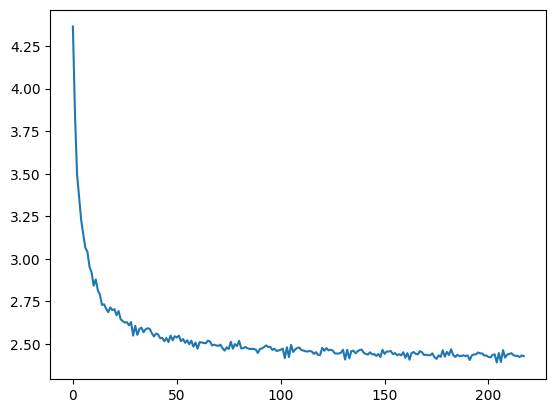

In [31]:
n = 100
plt.plot(torch.tensor(all_loss[:len(all_loss) // n * n]).view(-1, n).mean(1))
plt.show()

In [32]:
print("Train Loss:", find_loss(bigram_model, Xtr, Ytr))
print("Val Loss:", find_loss(bigram_model, Xval, Yval))

Train Loss: 2.427568197250366
Val Loss: 2.4947011470794678


In [33]:
g = torch.Generator().manual_seed(42)
ids = generate(bigram_model, generator=g)

print(tokenizer.decode(ids))

That be s wimale toteind t Ljshous "
cheisf s thired t t. stho h f tl LZ'sst kimese ilyoowhereridounin gas whert
hindklicum k s his Fod nowiche he cedidlend od ched g anto cid mumeste boitho lpa it
'Oheyof as ingwie atothe vea tt no ce p
stoufTHe KFo whive he incrid ofled s t
Nowaven aruY
